In [1]:
from PIL import Image
import pytesseract
import cv2
import pandas as pd

In [2]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Preprocesses an image for further processing.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: Preprocessed image.
    """

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply noise reduction if necessary
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.imshow(blurred,"grey")
    return blurred

In [4]:
import cv2
import numpy as np
import pytesseract

# Path to Tesseract executable (update this path according to your environment)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Units map for dimensions
unit_map = {
    'centimetre': ['cm', 'centimetre', 'centimeter'],
    'foot': ['ft', 'foot'],
    'inch': ['in', 'inch', '"'],
    'metre': ['m', 'metre', 'meter'],
    'millimetre': ['mm', 'millimetre', 'millimeter'],
    'yard': ['yd', 'yard']
}

# Function to detect text using the EAST detector
def detect_text_east(image_path):
    # Load the image
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    # Define the new width and height (divisible by 32 for EAST)
    newW, newH = (W // 32) * 32, (H // 32) * 32
    rW = W / float(newW)
    rH = H / float(newH)
    
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    
    # Load the pre-trained EAST model
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    
    # Construct a blob from the image and perform a forward pass of the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Get the output layers (scores and geometry data)
    (scores, geometry) = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])
    
    # Decode the predictions to obtain bounding boxes
    rectangles, confidences = decode_predictions(scores, geometry)
    
    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
    boxes = non_max_suppression(np.array(rectangles), probs=confidences)
    
    # Initialize the list of results
    results = []

    # Loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # Scale the coordinates back to the original image size
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        
        # Extract the region of interest (ROI) and use OCR to recognize the text
        roi = orig[startY:endY, startX:endX]
        text = pytesseract.image_to_string(roi, config="--psm 7")
        
        results.append(text.strip())
    
    return results

# Function to extract the desired dimension from the detected text
def extract_dimension(detected_text, dimension):
    # Iterate over detected text results
    for text in detected_text:
        # Check if the text contains any of the units
        for unit_category, units in unit_map.items():
            for unit in units:
                if unit in text:
                    # Now check if the text mentions the desired dimension (height, width, depth)
                    if dimension in text.lower():
                        # Return the text containing the dimension with the unit
                        return text
    return None

# Decoding predictions function
def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rectangles = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue

            offsetX, offsetY = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rectangles.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rectangles, confidences)

# Non-maxima suppression function
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

# Main function
def get_measurement(image_path, dimension):
    # Step 1: Detect the text in the image
    detected_text = detect_text_east(image_path)
    
    # Step 2: Extract the specific dimension (height, width, depth)
    dimension_value = extract_dimension(detected_text, dimension)
    
    # If a value is found, return it
    if dimension_value:
        return dimension_value
    else:
        return "Dimension not found in image."

# Example usage
image_path = "Width.jpg"
dimension = "width"  # Set the desired dimension ('width', 'height', or 'depth')
result = get_measurement(image_path, dimension)
print(result)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1138: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "frozen_east_text_detection.pb" in function 'cv::dnn::ReadProtoFromBinaryFile'


In [3]:
pytesseract.pytesseract.tesseract_cmd=r'C:\Program Files\Tesseract-OCR\tesseract.exe'
def extract_text(image):
    """Extracts text from an image.

    Args:
        image (np.ndarray): Preprocessed image.

    Returns:
        str: Extracted text.
    """

    text = pytesseract.image_to_string(image)

    return text

In [4]:
import re

def extract_dimensions(text):
    """Extracts height and width dimensions from the text.

    Args:
        text (str): Extracted text.

    Returns:
        tuple: (height, width)
    """
    # If no match, try extracting dimensions without units
    pattern1=r'(\d+(\.\d+)?)\s*\*\s*(\d+(\.\d+)?)\s*\*\s*(\d+(\.\d+)?)'
    match1 = re.search(pattern1, text)

    if match1:
        # Extract the width, height, and length
        dimensions = match1.groups()[0], match1.groups()[2]
        width, height= dimensions
        return width,height
    # Regular expression to match dimensions with units
    pattern2 = r"(?:(\d+(\.\d+)?)(cm|inch|mm))(?:x|by)(?:(\d+(\.\d+)?)(cm|inch|mm))"

    match2 = re.search(pattern2, text)

    if match2:
        height = int(match2.group(1))
        width = int(match2.group(4))
        return height, width
    return None, None

In [5]:
def extract_dimensions_from_image(image_path):
    """Extracts height and width dimensions from an image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: (height, width)
    """

    preprocessed_image = preprocess_image(image_path)
    extracted_text = extract_text(preprocessed_image)
    print(extracted_text)
    dimensions = extract_dimensions(extracted_text)

    return dimensions

,index,image_link,group_id,entity_name
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth
5,5,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,height
6,6,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,width
7,7,https://m.media-amazon.com/images/I/11lshEUmCr...,156839,height
8,8,https://m.media-amazon.com/images/I/21+i52HRW4...,478357,width
9,9,https://m.media-amazon.com/images/I/21-LmSmehZ...,478357,height


(15, 4)


Processing Images:   7%|████▎                                                           | 1/15 [00:00<00:07,  1.79it/s]


index: 0, prediction: None


Processing Images:  13%|████████▌                                                       | 2/15 [00:00<00:04,  2.60it/s]

‘42cm/16.54"

200cmv/78.74"

index: 1, prediction: None


Processing Images:  40%|█████████████████████████▌                                      | 6/15 [00:01<00:01,  6.79it/s]

‘42cm/16.54"

200cmv/78.74"

index: 2, prediction: None
Depth Found
index: 3, prediction: 
Depth Found
index: 4, prediction: 
10.80cm/4.13"

index: 5, prediction: None


Processing Images:  47%|█████████████████████████████▊                                  | 7/15 [00:01<00:01,  5.88it/s]

10.80cm/4.13"

index: 6, prediction: None


Processing Images:  53%|██████████████████████████████████▏                             | 8/15 [00:01<00:01,  5.44it/s]


index: 7, prediction: None


Processing Images:  60%|██████████████████████████████████████▍                         | 9/15 [00:01<00:01,  4.72it/s]

15 cm


index: 8, prediction: None


Processing Images:  67%|██████████████████████████████████████████                     | 10/15 [00:02<00:01,  4.40it/s]

15 cm


index: 9, prediction: None


Processing Images:  73%|██████████████████████████████████████████████▏                | 11/15 [00:02<00:00,  4.39it/s]


index: 11, prediction: None
Depth Found
index: 12, prediction: 


Processing Images:  87%|██████████████████████████████████████████████████████▌        | 13/15 [00:02<00:00,  5.67it/s]


index: 13, prediction: None


Processing Images: 100%|███████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  5.24it/s]


index: 14, prediction: None

index: 20, prediction: None


Processing Images: 100%|███████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.80it/s]


Final save: Remaining 15 predictions saved to widthTest_part_final.csv
All partial files concatenated into resultshalf.csv


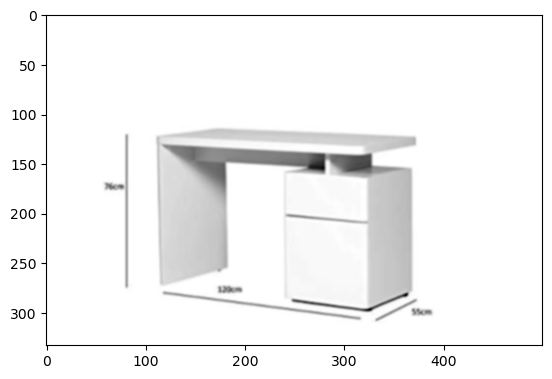

In [7]:
import pandas as pd
import os
import urllib.request
import time
from pathlib import Path
from tqdm import tqdm  
from PIL import Image
import glob  

def predictor(image_link, category_id, entity_name):
    '''
    Call your model/approach here
    '''
    
    if entity_name == 'width':
        return extract_dimensions_from_image(image_link)[1]
    elif entity_name == 'depth':
        print("Depth Found")
        return ""
    elif entity_name == 'height':
        return extract_dimensions_from_image(image_link)[0]
    else:
        return "Invalid entity name"
def create_placeholder_image(image_path, width=100, height=100):
    """
    Create a black placeholder image if the original image fails to download.

    Parameters:
    - image_path: The path where the placeholder image will be saved.
    - width: The width of the placeholder image (default is 100 pixels).
    - height: The height of the placeholder image (default is 100 pixels).
    """
    placeholder = Image.new('RGB', (width, height), color='black')
    
    placeholder.save(image_path)

def download_image(image_link, save_folder, retries=3, delay=3):
    if not isinstance(image_link, str):
        return

    filename = Path(image_link).name
    image_save_path = os.path.join(save_folder, filename)

    if os.path.exists(image_save_path):
        return image_save_path

    for _ in range(retries):
        try:
            urllib.request.urlretrieve(image_link, image_save_path)
            return image_save_path
        except:
            time.sleep(delay)
    
    create_placeholder_image(image_save_path)  
    return image_save_path

results_df = pd.DataFrame(columns=['index', 'prediction'])

def download_and_predict(image_link, save_folder, category_id, entity_name, retries=3, delay=3):
    image_save_path = download_image(image_link, save_folder, retries, delay)
    prediction = predictor(image_save_path, category_id, entity_name)
    return prediction

def process_images_from_csv(csv_path, download_folder, output_csv_path, save_interval=5000):
    df = pd.read_csv(csv_path)
    display(df)
    print(df.shape)

    image_links = df['image_link'].tolist()
    categories = df['group_id'].tolist()
    entities = df['entity_name'].tolist()
    indices = df['index'].tolist()  

    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    results = []

    for i, (image_link, category_id, entity_name, index) in enumerate(tqdm(zip(image_links, categories, entities, indices), total=len(image_links), desc="Processing Images")):
        
        prediction = download_and_predict(image_link, download_folder, category_id, entity_name)
        print(f'index: {index}, prediction: {prediction}')
        results.append({'index': index, 'prediction': prediction})

        if (i + 1) % save_interval == 0:
            results_df = pd.DataFrame(results)
            
            partial_output_csv = output_csv_path.replace(".csv", f"_part_{(i + 1) // save_interval}.csv")
            results_df.to_csv(partial_output_csv, index=False)
            print(f"Saved progress after {i + 1} predictions to {partial_output_csv}")
            
            results.clear()

    
    if results:
        results_df = pd.DataFrame(results)
        partial_output_csv = output_csv_path.replace(".csv", f"_part_final.csv")
        results_df.to_csv(partial_output_csv, index=False)
        print(f"Final save: Remaining {len(results)} predictions saved to {partial_output_csv}")

        concatenate_results(output_csv_path)

def concatenate_results(final_output_csv):
    """
    Concatenate all partial CSV files into one final file.
    
    Parameters:
    - final_output_csv: The path where the final concatenated CSV will be saved.
    """
    
    partial_csvs = glob.glob(final_output_csv.replace(".csv", "_part_*.csv"))
    
    partial_csvs.sort()

    combined_df = pd.concat([pd.read_csv(csv_file) for csv_file in partial_csvs])

    combined_df.to_csv('resultshalf.csv', index=False)
    print(f"All partial files concatenated into resultshalf.csv")

process_images_from_csv('testWidthMini.csv', 'download_folder', 'widthTest.csv')


image_path = r"C:\Users\devin\Desktop\Amazon_ML\student_resource 3\dataset\train_img\61Drr5Mq3nL.jpg"
width,height = extract_dimensions_from_image(image_path)

if height or width:
    print("Height:", height)
    print("Width:", width)
else:
    print("Unable to extract dimensions.")